Multiplexed sequencing
======================

The Cluster QRM/QCM supports six sequencers. The output of each sequencer is multiplexed, accumulated and connected to the output ports of the instrument.

- In the first part of the tutorial we will demonstrate how to connect multiple sequencers to a single pair of output ports.
- In the second part of the tutorial we will demonstrate frequency multiplexing by assigning different unique modulation frequencies (frequency of the carrier) to the sequencers. We will then show how to acquire, demodulate, and integrate the received frequency multiplexed waveforms.
- In the third part of the tutorial we will demonstrate \"real mode\", where we will output real signals on each individual output port of the instrument.

We will show this by using a [QRM](https://qblox-qblox-instruments.readthedocs-hosted.com/en/main/cluster/qrm.html) and connecting outputs $\text{O}^{[1-2]}$ to inputs $\text{I}^{[1-2]}$ respectively. We will then use the QRM's sequencers to sequence waveforms on
the outputs and simultaneously acquire the resulting waveforms on the inputs (using the same sequencers).

Setup
-----

First, we are going to import the required packages.

In [1]:
from __future__ import annotations

import json
import math
from typing import TYPE_CHECKING, Callable

import matplotlib.pyplot as plt
import numpy as np
import scipy.signal
from qcodes.instrument import find_or_create_instrument
from scipy.fft import rfft, rfftfreq

from qblox_instruments import Cluster, ClusterType

if TYPE_CHECKING:
    from qblox_instruments.qcodes_drivers.module import QcmQrm

### Scan For Clusters

We scan for the available devices connected via ethernet using the Plug & Play functionality of the Qblox Instruments package (see [Plug & Play](https://qblox-qblox-instruments.readthedocs-hosted.com/en/main/api_reference/tools.html#api-pnp) for more info).

In [2]:
!qblox-pnp list

No devices found


In [3]:
cluster_ip = "10.10.200.42"
cluster_name = "cluster0"

### Connect to Cluster

We now make a connection with the Cluster.

In [4]:
cluster = find_or_create_instrument(
    Cluster,
    recreate=True,
    name=cluster_name,
    identifier=cluster_ip,
    dummy_cfg=(
        {
            2: ClusterType.CLUSTER_QCM,
            4: ClusterType.CLUSTER_QRM,
            6: ClusterType.CLUSTER_QCM_RF,
            8: ClusterType.CLUSTER_QRM_RF,
        }
        if cluster_ip is None
        else None
    ),
)

#### Get connected modules

In [5]:
def get_connected_modules(cluster: Cluster, filter_fn: Callable | None = None) -> dict[int, QcmQrm]:
    def checked_filter_fn(mod: ClusterType) -> bool:
        if filter_fn is not None:
            return filter_fn(mod)
        return True

    return {
        mod.slot_idx: mod for mod in cluster.modules if mod.present() and checked_filter_fn(mod)
    }

In [6]:
# QRM baseband modules
modules = get_connected_modules(cluster, lambda mod: mod.is_qrm_type and not mod.is_rf_type)
modules

{4: <Module: cluster0_module4 of Cluster: cluster0>}

In [7]:
readout_module = modules[4]

### Reset the Cluster

We reset the Cluster to enter a well-defined state. Note that resetting will clear all stored parameters, so resetting between experiments is usually not desirable.

In [8]:
cluster.reset()
print(cluster.get_system_status())

Status: OKAY, Flags: NONE, Slot flags: NONE


Generate waveforms <a id='gen_wf'></a>
------------------

Next, we need to create the gaussian and block waveforms for the sequence.

In [9]:
# Waveforms
waveform_len = 1000
waveforms = {
    "gaussian": {
        "data": scipy.signal.windows.gaussian(waveform_len, std=0.133 * waveform_len).tolist(),
        "index": 0,
    },
    "sine": {
        "data": [math.sin((2 * math.pi / waveform_len) * i) for i in range(0, waveform_len)],
        "index": 1,
    },
    "sawtooth": {
        "data": [(1.0 / waveform_len) * i for i in range(0, waveform_len)],
        "index": 2,
    },
    "block": {"data": [1.0 for i in range(0, waveform_len)], "index": 3},
}

Let's plot the waveforms to see what we have created.

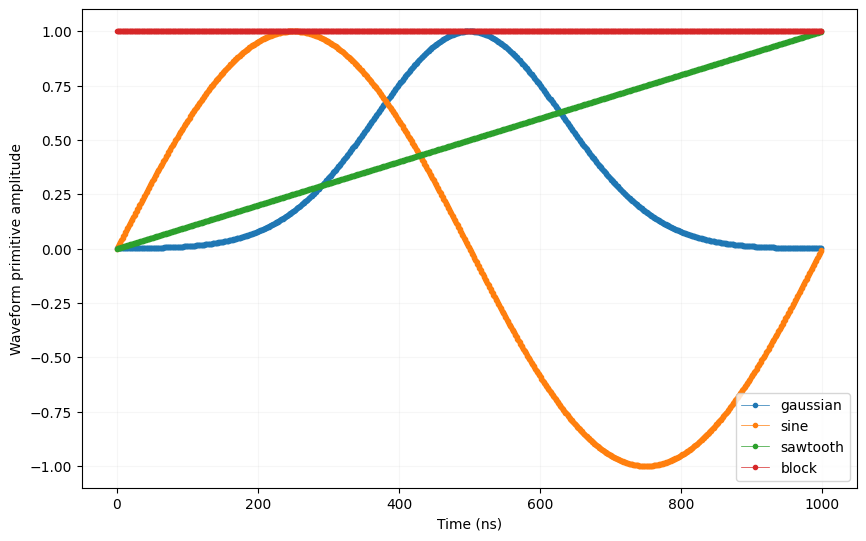

In [10]:
time = np.arange(0, max(map(lambda d: len(d["data"]), waveforms.values())), 1)
fig, ax = plt.subplots(1, 1, figsize=(10, 10 / 1.61))

for wf, d in waveforms.items():
    ax.plot(time[: len(d["data"])], d["data"], ".-", linewidth=0.5, label=wf)

ax.legend(loc=4)
ax.grid(alpha=1 / 10)
ax.set_ylabel("Waveform primitive amplitude")
ax.set_xlabel("Time (ns)")

plt.draw()
plt.show()

Specify the acquisitions
--------------------

We will only use a single bin in this tutorial, so we can keep it simple

In [11]:
# Acquisitions
acquisitions = {"scope": {"num_bins": 1, "index": 0}}

Create Q1ASM program and upload the sequence
--------------------

Now that we have the waveform and acquisition specifications for the sequence, we need a simple Q1ASM program that sequences the waveforms and triggers the acquisitions. In this case we will play a gaussian and a sinusoid wave for path 0 and 1 respectively per sequencer.

In [12]:
# Number of sequencers per instrument
num_seq = 6

# Program
program = """
wait_sync 4
play      0,1,4
wait      140
acquire   0,0,16380
stop
"""

# Write sequence to file.
with open("sequence.json", "w", encoding="utf-8") as file:
    json.dump(
        {
            "waveforms": waveforms,
            "weights": waveforms,
            "acquisitions": acquisitions,
            "program": program,
        },
        file,
        indent=4,
    )
    file.close()

# Program sequencers.
for sequencer in readout_module.sequencers:
    sequencer.sequence("sequence.json")

Multiplexed sequencer output control
------------------------------------
Each sequencer has two output paths. The output paths of each sequencer are physically connected to the instrument's outputs. It is possible to map any sequencer output path to any output port by using the sequencer's channel map.

We can do so by calling `sequencerX.connect_outY(Z)` where `X`, `Y` and `Z` represents sequencer ID $\in[0,..,5]$, output port number, and `Z`$\in \{$`"off"`, `"I"`, `"Q"`$\}$.

For most common sequencer configurations, the convenience function `sequencerX.connect_sequencer(config)` can be used to easily set the channel map. Some examples:

Multiplexed sequencers on a QRM baseband
```python
instrument.disconnect_inputs()
instrument.disconnect_outputs()
for seq in instrument.sequencers:
    seq.connect_sequencer("io0_1")
```

Multiplexed sequencers on a QRM-RF
```python
instrument.disconnect_inputs()
instrument.disconnect_outputs()
for seq in instrument.sequencers:
    seq.connect_sequencer("io0")
```

Sequencers 1:1 on a QCM baseband
```python
instrument.disconnect_outputs()
for idx in range(4):
    instrument[f"sequencer{idx}"].connect_sequencer(f"out{idx}")
```

Sequencers 1:1 on a QCM-RF
```python
instrument.disconnect_outputs()
for idx in range(2):
    instrument[f"sequencer{idx}"].connect_sequencer(f"out{idx}")
```

For the sake of this tutorial we will map the <span style="color:#ed1c24">in-phase path</span> of each sequencer to the ports with the even output port numbers (indexed from 0) and the <span style="color:#37b5b9">quadrature path</span> of each sequencer to the ports with the odd output port numbers.
<!---
, like is shown in the figure below. Note that this figure is for the [QCM](https://qblox-qblox-instruments.readthedocs-hosted.com/en/main/cluster/qcm.html), so it has 4 outputs.

<img src="https://qblox-qblox-instruments.readthedocs-hosted.com/en/main/cluster/figures/QBLOX_MULTIPLEXING_DIAGRAM.svg" alt="drawing" width="1000"/>
-->

Now lets configure the first sequencer to output its <span style="color:#ed1c24">in-phase</span> and <span style="color:#37b5b9">quadrature</span> paths on $\text{O}^{1}$ and $\text{O}^{2}$ respectively. We will scale the amplitude of the signal such that we are able the show what happens when other sequencers are added and eventually output overflow occurs.

We will also configure the channel map so that inputs $\text{I}^{[1-2]}$ of the QRM are mapped to the <span style="color:#ed1c24">in-phase</span> and <span style="color:#37b5b9">quadrature</span> input paths of the same sequencer.

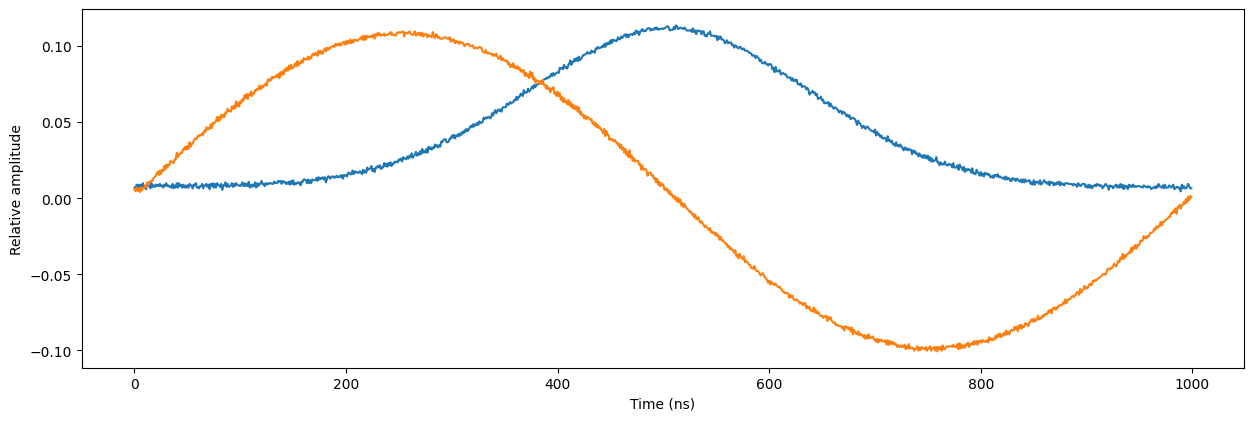

In [13]:
# Configure the sequencer to trigger the scope acquisition.
readout_module.scope_acq_sequencer_select(0)
readout_module.scope_acq_trigger_mode_path0("sequencer")
readout_module.scope_acq_trigger_mode_path1("sequencer")

# Configure sequencer
readout_module.sequencer0.sync_en(True)
readout_module.sequencer0.gain_awg_path0(
    1.1 / num_seq
)  # The output range is 1.0 to -1.0, but we want to show what happens when the signals go out of range.
readout_module.sequencer0.gain_awg_path1(1.1 / num_seq)

readout_module.disconnect_outputs()
readout_module.disconnect_inputs()

# connect output paths of the sequencer
readout_module.sequencer0.connect_out0("I")
readout_module.sequencer0.connect_out1("Q")

# connect input paths of the same sequencer.
readout_module.sequencer0.connect_acq_I("in0")
readout_module.sequencer0.connect_acq_Q("in1")

# Start the sequence
readout_module.arm_sequencer(0)
readout_module.start_sequencer()

# Wait for the sequencer to stop
readout_module.get_acquisition_status(0)

# Get acquisition data
readout_module.store_scope_acquisition(0, "scope")
acq = readout_module.get_acquisitions(0)

# Plot the results
fig, ax = plt.subplots(1, 1, figsize=(15, 15 / 2 / 1.61))

ax.plot(acq["scope"]["acquisition"]["scope"]["path0"]["data"][0:waveform_len])
ax.plot(acq["scope"]["acquisition"]["scope"]["path1"]["data"][0:waveform_len])
ax.set_xlabel("Time (ns)")
ax.set_ylabel("Relative amplitude")

plt.show()

Let's add the second sequencer.

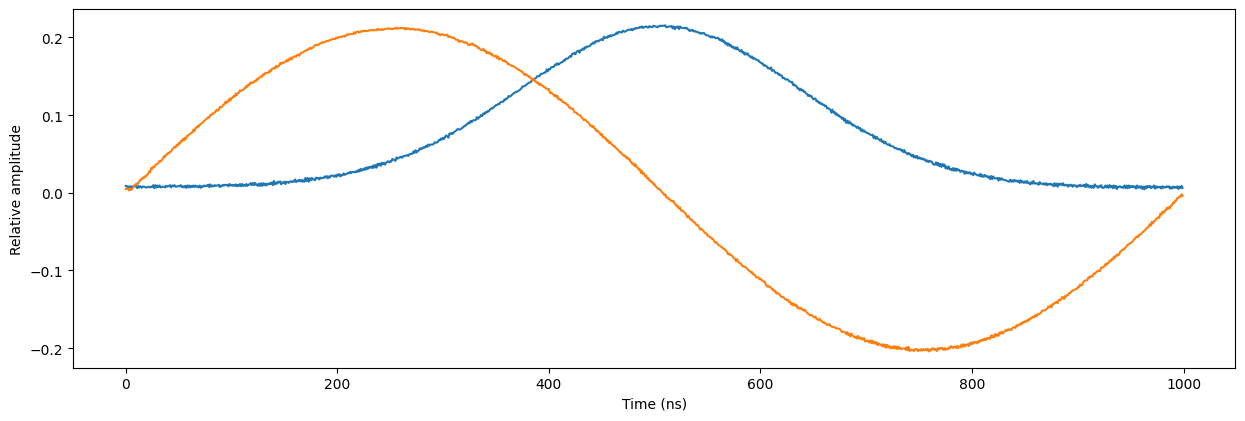

In [14]:
# Configure the sequencer
readout_module.sequencer1.sync_en(True)
readout_module.sequencer1.gain_awg_path0(1.1 / num_seq)
readout_module.sequencer1.gain_awg_path1(1.1 / num_seq)

readout_module.sequencer1.connect_out0("I")
readout_module.sequencer1.connect_out1("Q")

# connect input paths of the same sequencer.
readout_module.sequencer1.connect_acq_I("in0")
readout_module.sequencer1.connect_acq_Q("in1")

# Start the sequencers
for seq in range(0, 2):
    readout_module.arm_sequencer(seq)
readout_module.start_sequencer()

# Wait for sequencers to stop
for seq in range(0, 2):
    readout_module.get_acquisition_status(seq)

# Get acquisition data
readout_module.store_scope_acquisition(0, "scope")
acq = readout_module.get_acquisitions(0)

# Plot the results
fig, ax = plt.subplots(1, 1, figsize=(15, 15 / 2 / 1.61))

ax.plot(acq["scope"]["acquisition"]["scope"]["path0"]["data"][0:waveform_len])
ax.plot(acq["scope"]["acquisition"]["scope"]["path1"]["data"][0:waveform_len])
ax.set_xlabel("Time (ns)")
ax.set_ylabel("Relative amplitude")

plt.show()

Let's add the third sequencer.

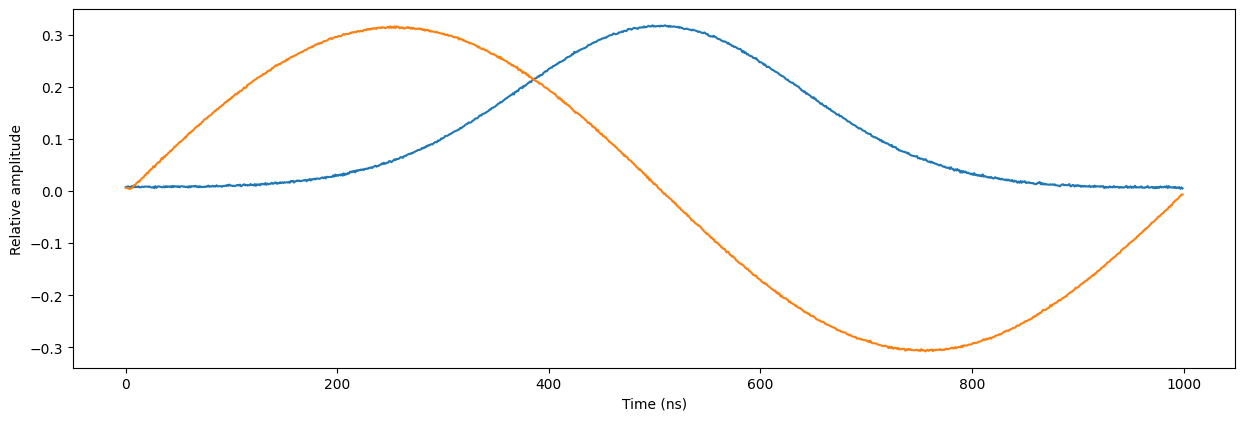

In [15]:
# Configure the sequencer
readout_module.sequencer2.sync_en(True)
readout_module.sequencer2.gain_awg_path0(1.1 / num_seq)
readout_module.sequencer2.gain_awg_path1(1.1 / num_seq)

readout_module.sequencer2.connect_out0("I")
readout_module.sequencer2.connect_out1("Q")

# connect input paths of the same sequencer.
readout_module.sequencer2.connect_acq_I("in0")
readout_module.sequencer2.connect_acq_Q("in1")

# Start the sequencers
for seq in range(0, 3):
    readout_module.arm_sequencer(seq)
readout_module.start_sequencer()

# Wait for sequencers to stop
for seq in range(0, 3):
    readout_module.get_acquisition_status(seq)

# Get acquisition data
readout_module.store_scope_acquisition(0, "scope")
acq = readout_module.get_acquisitions(0)

# Plot the results
fig, ax = plt.subplots(1, 1, figsize=(15, 15 / 2 / 1.61))

ax.plot(acq["scope"]["acquisition"]["scope"]["path0"]["data"][0:waveform_len])
ax.plot(acq["scope"]["acquisition"]["scope"]["path1"]["data"][0:waveform_len])
ax.set_xlabel("Time (ns)")
ax.set_ylabel("Relative amplitude")

plt.show()

Let's add the fourth sequencer.

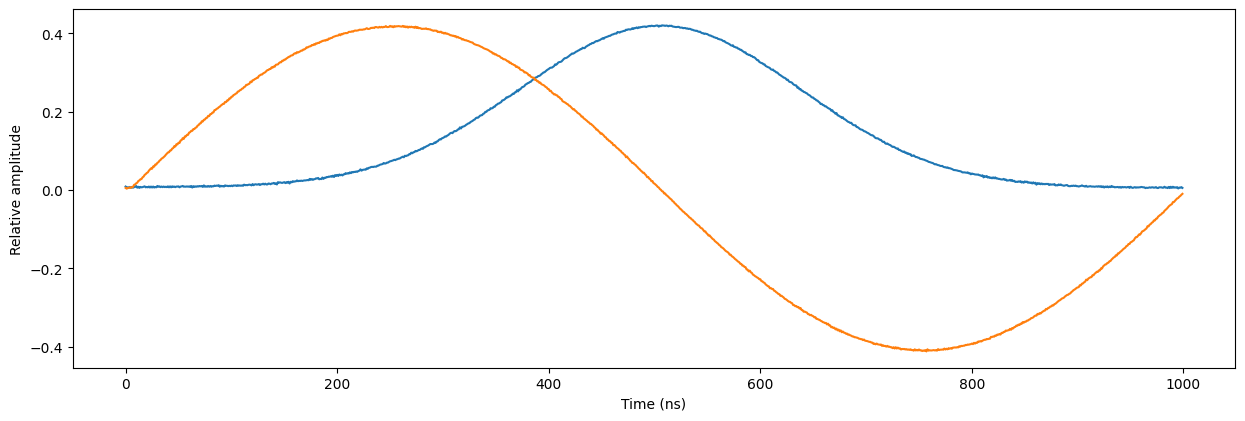

In [16]:
# Configure the sequencer
readout_module.sequencer3.sync_en(True)
readout_module.sequencer3.gain_awg_path0(1.1 / num_seq)
readout_module.sequencer3.gain_awg_path1(1.1 / num_seq)

readout_module.sequencer3.connect_out0("I")
readout_module.sequencer3.connect_out1("Q")

# connect input paths of the same sequencer.
readout_module.sequencer3.connect_acq_I("in0")
readout_module.sequencer3.connect_acq_Q("in1")

# Start the sequencers
for seq in range(0, 4):
    readout_module.arm_sequencer(seq)
readout_module.start_sequencer()

# Wait for sequencers to stop
for seq in range(0, 4):
    readout_module.get_acquisition_status(seq)

# Get acquisition data
readout_module.store_scope_acquisition(0, "scope")
acq = readout_module.get_acquisitions(0)

# Plot the results
fig, ax = plt.subplots(1, 1, figsize=(15, 15 / 2 / 1.61))

ax.plot(acq["scope"]["acquisition"]["scope"]["path0"]["data"][0:waveform_len])
ax.plot(acq["scope"]["acquisition"]["scope"]["path1"]["data"][0:waveform_len])
ax.set_xlabel("Time (ns)")
ax.set_ylabel("Relative amplitude")

plt.show()

Let's add the fifth sequencer.

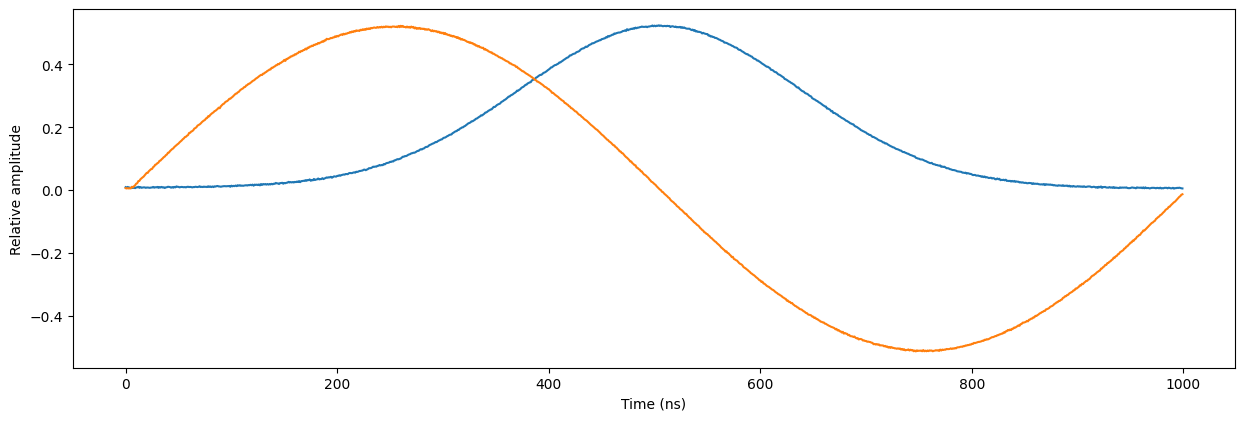

In [17]:
# Configure the sequencer
readout_module.sequencer4.sync_en(True)
readout_module.sequencer4.gain_awg_path0(1.1 / num_seq)
readout_module.sequencer4.gain_awg_path1(1.1 / num_seq)

readout_module.sequencer4.connect_out0("I")
readout_module.sequencer4.connect_out1("Q")

# connect input paths of the same sequencer.
readout_module.sequencer4.connect_acq_I("in0")
readout_module.sequencer4.connect_acq_Q("in1")

# Start the sequencers
for seq in range(0, 5):
    readout_module.arm_sequencer(seq)
readout_module.start_sequencer()

# Wait for sequencers to stop
for seq in range(0, 5):
    readout_module.get_acquisition_status(seq)

# Get acquisition data
readout_module.store_scope_acquisition(0, "scope")
acq = readout_module.get_acquisitions(0)

# Plot the results
fig, ax = plt.subplots(1, 1, figsize=(15, 15 / 2 / 1.61))

ax.plot(acq["scope"]["acquisition"]["scope"]["path0"]["data"][0:waveform_len])
ax.plot(acq["scope"]["acquisition"]["scope"]["path1"]["data"][0:waveform_len])
ax.set_xlabel("Time (ns)")
ax.set_ylabel("Relative amplitude")

plt.show()

Let's add the sixth sequencer.

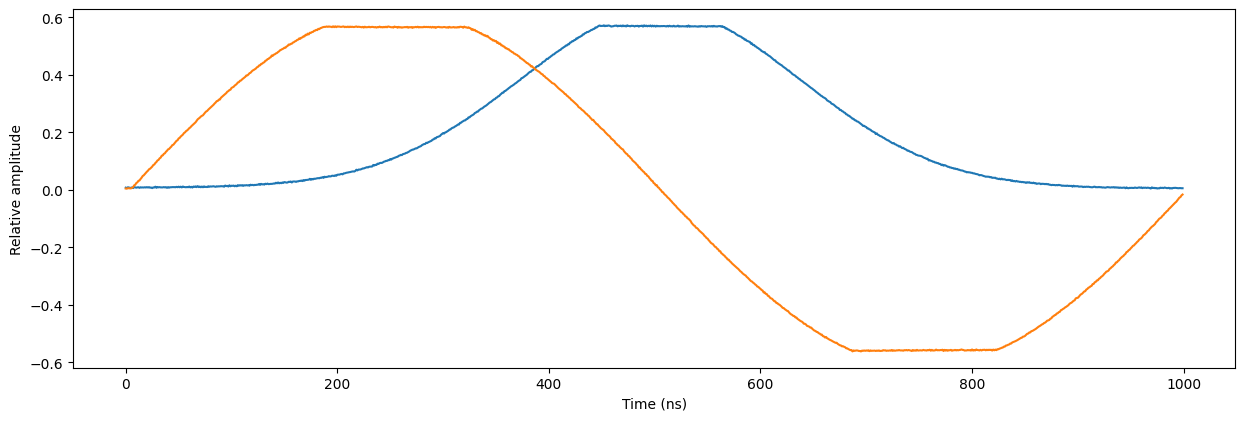

In [18]:
# Configure the sequencer
readout_module.sequencer5.sync_en(True)
readout_module.sequencer5.gain_awg_path0(1.1 / num_seq)
readout_module.sequencer5.gain_awg_path1(1.1 / num_seq)

readout_module.sequencer5.connect_out0("I")
readout_module.sequencer5.connect_out1("Q")

# connect input paths of the same sequencer.
readout_module.sequencer5.connect_acq_I("in0")
readout_module.sequencer5.connect_acq_Q("in1")

# Start the sequencers
for seq in range(0, 6):
    readout_module.arm_sequencer(seq)
readout_module.start_sequencer()

# Wait for sequencers to stop
for seq in range(0, 6):
    readout_module.get_acquisition_status(seq)

# Get acquisition data
readout_module.store_scope_acquisition(0, "scope")
acq = readout_module.get_acquisitions(0)

# Plot the results
fig, ax = plt.subplots(1, 1, figsize=(15, 15 / 2 / 1.61))

ax.plot(acq["scope"]["acquisition"]["scope"]["path0"]["data"][0:waveform_len])
ax.plot(acq["scope"]["acquisition"]["scope"]["path1"]["data"][0:waveform_len])
ax.set_xlabel("Time (ns)")
ax.set_ylabel("Relative amplitude")

plt.show()

Note that now the outputs overflow and the output signal is clipped as intended. Also note that the output range of a QRM is 1 Vpp, while it's input range is 2 Vpp. This causes the signal in the figure to be clipped at 0.5 and -0.5.

Frequency multiplexing
----------------------
Next, we will show frequency multiplexing. We will connect the outputs of various sequencers to a single output port pair, modulate their waveforms on unique carrier frequencies and in turn acquire, demodulate and integrate the results fed back into the inputs to validate the acquired signals. In this case, for simplicity, we will modulate a square wave pulse on each sequencer and we will play with the output gain. In order to visualize the frequency multiplexing, we will preform an FFT over the acquired scope acquisitions.

In [19]:
# Reset
if cluster:
    cluster.reset()
else:
    readout_module.reset()
# Program
program = """
      wait_sync 4
loop: play      3,3,4
      wait      140
      acquire   0,0,16380
      stop
"""

# Write sequence to file
with open("sequence.json", "w", encoding="utf-8") as file:
    json.dump(
        {
            "waveforms": waveforms,
            "weights": waveforms,
            "acquisitions": acquisitions,
            "program": program,
        },
        file,
        indent=4,
    )
    file.close()

Lets start with a single sequencer with an AWG gain of 1.0 (only on path 0 to create a "real" pulse). Let's modulate it's output with a carrier frequency of 20MHz.

In [20]:
# Program sequencer
readout_module.sequencer0.sequence("sequence.json")

readout_module.disconnect_outputs()
readout_module.disconnect_inputs()

# connect output paths of the sequencer
readout_module.sequencer0.connect_out0("I")
readout_module.sequencer0.connect_out1("Q")

# connect input paths of the same sequencer.
readout_module.sequencer0.connect_acq_I("in0")
readout_module.sequencer0.connect_acq_Q("in1")

# Configure sequencer
readout_module.sequencer0.sync_en(True)
readout_module.sequencer0.gain_awg_path0(1.0)
readout_module.sequencer0.gain_awg_path1(0.0)
readout_module.sequencer0.nco_freq(20e6)
readout_module.sequencer0.mod_en_awg(True)
readout_module.sequencer0.demod_en_acq(True)
readout_module.sequencer0.integration_length_acq(waveform_len)

In [21]:
# Start the sequencer
readout_module.arm_sequencer(0)
readout_module.start_sequencer(0)

# Wait for the sequencer to stop
readout_module.get_acquisition_status(0)

# Get acquisition data
readout_module.store_scope_acquisition(0, "scope")
acq = readout_module.get_acquisitions(0)

Now lets have a look at the FFT of the scope acquisition to verify the presence of one tone at 20MHz.

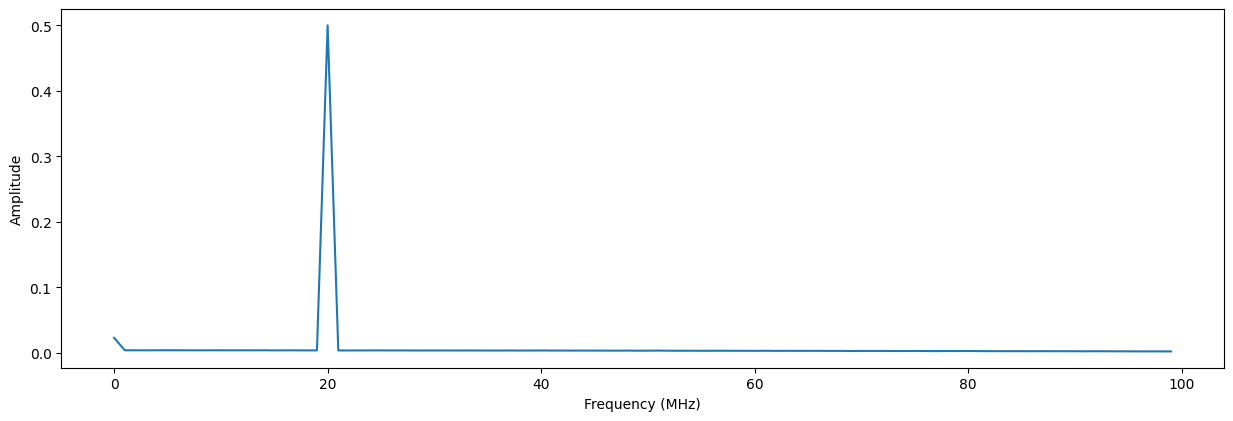

In [22]:
# Plot the FFT
fig, bx = plt.subplots(1, 1, figsize=(15, 15 / 2 / 1.61))
yf = abs(rfft(acq["scope"]["acquisition"]["scope"]["path0"]["data"][0:waveform_len]))
xf = rfftfreq(1000, 1 / 1e3)
norm_fact = readout_module.sequencer0.gain_awg_path0() / 2 / np.max(yf)
bx.plot(xf[0:100], yf[0:100] * norm_fact)
bx.set_xlabel("Frequency (MHz)")
bx.set_ylabel("Amplitude")
plt.show()

Now let's have a look at the hardware demodulated and integrated results and check if it matches our expectations. Don't forget that we need to divide the integration results by the integration length. In this case, the integration length is the same as the waveform length.

In [23]:
bins = acq["scope"]["acquisition"]["bins"]
I_data = bins["integration"]["path0"][0] / waveform_len
Q_data = bins["integration"]["path1"][0] / waveform_len
print("Integration results:")
print(f"I = {I_data}")
print(f"Q = {Q_data}")
print(f"R = sqrt(I^2 + Q^2) = {math.sqrt(I_data**2 + Q_data**2)}")

Integration results:
I = 0.5561592574499267
Q = 0.04270835368832438
R = sqrt(I^2 + Q^2) = 0.5577966682600577


The pulse acquired at the inputs is automatically demodulated at 20MHz, but due to phase rotation caused by output-to-input latency the result is not purely real. However the amplitude of the IQ vector is 0.5 as expected because: 1Vpp output range / 2Vpp input range = 0.5.

Now lets increase the number of sequencers to three, each with a slightly different AWG gain. We will modulate the signals of sequencer 0 to 2 with a carrier frequencies at 20MHz, 30MHz and 40MHz respectively.

In [24]:
num_seq = 3
for seq in range(0, num_seq):
    # Program sequencers
    readout_module.sequencers[seq].sequence("sequence.json")

    # Configure the channel map
    readout_module.sequencers[seq].connect_out0("I")
    readout_module.sequencers[seq].connect_out1("Q")

    # Connect input paths of the same sequencer.
    readout_module.sequencers[seq].connect_acq_I("in0")
    readout_module.sequencers[seq].connect_acq_Q("in1")

    # Configure the sequencers
    readout_module.sequencers[seq].sync_en(True)
    readout_module.sequencers[seq].mod_en_awg(True)
    readout_module.sequencers[seq].demod_en_acq(True)
    readout_module.sequencers[seq].integration_length_acq(waveform_len)

# Set the gains
readout_module.sequencer0.gain_awg_path0(0.5)
readout_module.sequencer0.gain_awg_path1(0.0)
readout_module.sequencer1.gain_awg_path0(0.25)
readout_module.sequencer1.gain_awg_path1(0.0)
readout_module.sequencer2.gain_awg_path0(0.125)
readout_module.sequencer2.gain_awg_path1(0.0)

# Set the frequencies
readout_module.sequencer0.nco_freq(20e6)
readout_module.sequencer1.nco_freq(30e6)
readout_module.sequencer2.nco_freq(40e6)

In [25]:
# Start the sequencers
for seq in range(0, 3):
    readout_module.arm_sequencer(seq)
readout_module.start_sequencer()

# Wait for sequencers to stop
for seq in range(0, 3):
    readout_module.get_acquisition_status(seq)

# Get acquisition data
readout_module.store_scope_acquisition(0, "scope")
acq = readout_module.get_acquisitions(0)

Now lets have a look at the FFT of the scope acquisition to verify the presence of three tones at 20MHz, 30Mhz and 40MHz.

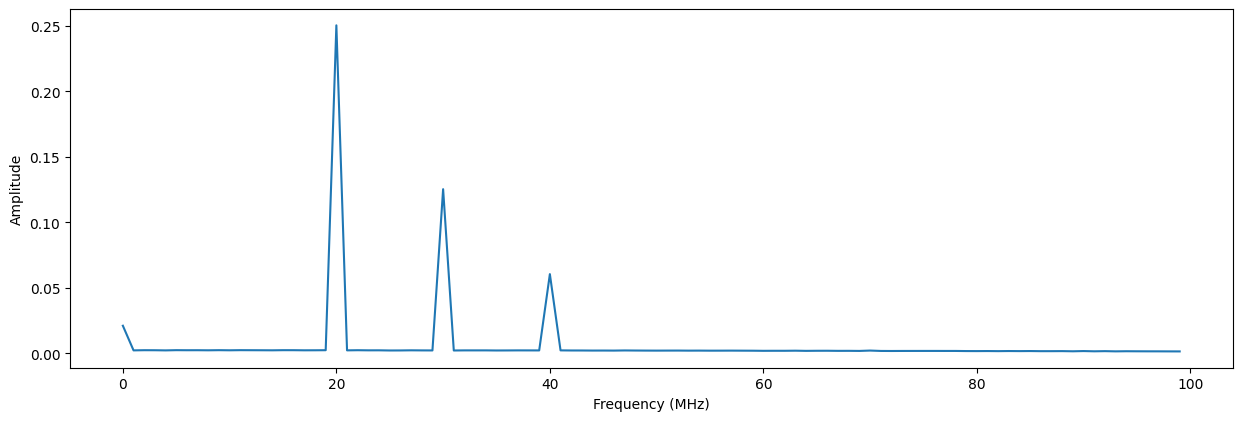

In [26]:
# Plot the FFT
fig, bx = plt.subplots(1, 1, figsize=(15, 15 / 2 / 1.61))
yf = abs(rfft(acq["scope"]["acquisition"]["scope"]["path0"]["data"][0:waveform_len]))
xf = rfftfreq(1000, 1 / 1e3)
bx.plot(xf[0:100], yf[0:100] * norm_fact)
bx.set_xlabel("Frequency (MHz)")
bx.set_ylabel("Amplitude")
plt.show()

Now let's check if the hardware demodulated and integrated results match our expectations.

In [27]:
for seq in range(0, num_seq):
    readout_module.store_scope_acquisition(seq, "scope")
    acq = readout_module.get_acquisitions(seq)
    bins = acq["scope"]["acquisition"]["bins"]
    I_data = bins["integration"]["path0"][0] / waveform_len
    Q_data = bins["integration"]["path1"][0] / waveform_len
    print(f"Sequencer {seq}")
    print("Integration results:")
    print(f"I = {I_data}")
    print(f"Q = {Q_data}")
    print(f"R = sqrt(I^2 + Q^2) = {math.sqrt(I_data**2 + Q_data**2)}")
    print("---------------------------------------------------------------------------------")

Sequencer 0
Integration results:
I = 0.278732779677577
Q = 0.02196922325354177
R = sqrt(I^2 + Q^2) = 0.27959722680518956
---------------------------------------------------------------------------------
Sequencer 1
Integration results:
I = -0.13905471421592575
Q = -0.015300439667806547
R = sqrt(I^2 + Q^2) = 0.13989394911754036
---------------------------------------------------------------------------------
Sequencer 2
Integration results:
I = 0.06665852467024914
Q = 0.011223253541768442
R = sqrt(I^2 + Q^2) = 0.06759674793417973
---------------------------------------------------------------------------------


Again, the acquired signals on the input are automatically demodulated at 20MHz, 30MHz and 40MHz and we see that the amplitude of the IQ vectors match the gain values we set divided by two, which matches our expectations.

Now, let's try it one final time with six sequencers, each with 0.15 AWG gain. We will modulate the outputs of sequencer 0 to 5 with carrier frequencies at 20MHz, 30Mhz, 40MHz, 50MHz, 60MHz and 70MHz respectively.

In [28]:
num_seq = 6
for seq in range(0, num_seq):
    # Program sequencers
    readout_module.sequencers[seq].sequence("sequence.json")

    # Configure the channel map
    readout_module.sequencers[seq].connect_out0("I")
    readout_module.sequencers[seq].connect_out1("Q")

    # Connect input paths of the same sequencer.
    readout_module.sequencers[seq].connect_acq_I("in0")
    readout_module.sequencers[seq].connect_acq_Q("in1")

    # Configure the sequencers
    readout_module.sequencers[seq].sync_en(True)
    readout_module.sequencers[seq].gain_awg_path0(0.15)
    readout_module.sequencers[seq].gain_awg_path1(0.0)
    readout_module.sequencers[seq].mod_en_awg(True)
    readout_module.sequencers[seq].demod_en_acq(True)
    readout_module.sequencers[seq].integration_length_acq(waveform_len)

# Set the frequencies
readout_module.sequencer0.nco_freq(20e6)
readout_module.sequencer1.nco_freq(30e6)
readout_module.sequencer2.nco_freq(40e6)
readout_module.sequencer3.nco_freq(50e6)
readout_module.sequencer4.nco_freq(60e6)
readout_module.sequencer5.nco_freq(70e6)

In [29]:
# Start the sequencers
for seq in range(0, 6):
    readout_module.arm_sequencer(seq)
readout_module.start_sequencer()

# Wait for sequencers to stop
for seq in range(0, 6):
    readout_module.get_acquisition_status(seq)

# Get acquisition data
readout_module.store_scope_acquisition(0, "scope")
acq = readout_module.get_acquisitions(0)

Now lets have a look at the FFT of the scope acquisition to verify the presence of six tones at 20MHz, 30Mhz, 40MHz, 50MHz, 60MHz and 70MHz

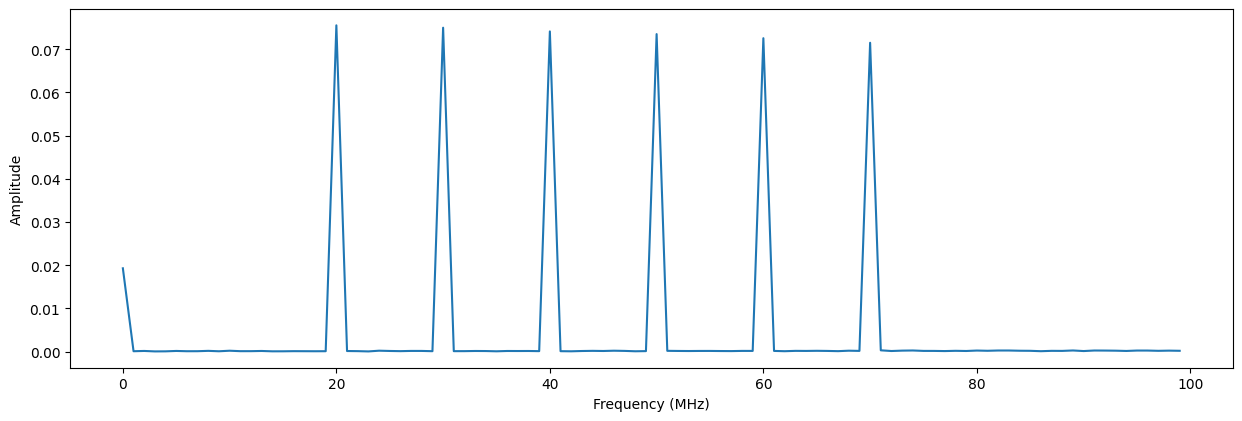

In [30]:
# Plot the FFT
fig, bx = plt.subplots(1, 1, figsize=(15, 15 / 2 / 1.61))
yf = abs(rfft(acq["scope"]["acquisition"]["scope"]["path0"]["data"][0:waveform_len]))
xf = rfftfreq(1000, 1 / 1e3)
bx.plot(xf[0:100], yf[0:100] * norm_fact)
bx.set_xlabel("Frequency (MHz)")
bx.set_ylabel("Amplitude")
plt.show()

Note that we lose a little bit of power over the frequency range, but that is to be expected due to frequency dependant components in the output and input path. Now let's check if the hardware demodulated and integrated results match our expectations.

In [31]:
for seq in range(0, num_seq):
    readout_module.store_scope_acquisition(seq, "scope")
    acq = readout_module.get_acquisitions(seq)
    bins = acq["scope"]["acquisition"]["bins"]
    I_data = bins["integration"]["path0"][0] / waveform_len
    Q_data = bins["integration"]["path1"][0] / waveform_len
    print(f"Sequencer {seq}")
    print("Integration results:")
    print(f"I = {I_data}")
    print(f"Q = {Q_data}")
    print(f"R = sqrt(I^2 + Q^2) = {math.sqrt(I_data**2 + Q_data**2)}")
    print("---------------------------------------------------------------------------------")

Sequencer 0
Integration results:
I = 0.08383732291157792
Q = 0.006258915486077187
R = sqrt(I^2 + Q^2) = 0.08407062944954108
---------------------------------------------------------------------------------
Sequencer 1
Integration results:
I = -0.0832266731802638
Q = -0.009926233512457255
R = sqrt(I^2 + Q^2) = 0.08381652128547375
---------------------------------------------------------------------------------
Sequencer 2
Integration results:
I = 0.08155593551538837
Q = 0.01285686370297997
R = sqrt(I^2 + Q^2) = 0.0825631247111396
---------------------------------------------------------------------------------
Sequencer 3
Integration results:
I = -0.0802237420615535
Q = -0.0169438202247191
R = sqrt(I^2 + Q^2) = 0.08199354751543726
---------------------------------------------------------------------------------
Sequencer 4
Integration results:
I = 0.0784103566194431
Q = 0.020122129946262824
R = sqrt(I^2 + Q^2) = 0.08095112191169762
-------------------------------------------------------

Taking the power loss over frequency into account, the amplitudes of the IQ vectors match our expectations again.


Real mode
---------------

Many applications require multiple outputs to be controlled independently and only output real signals instead of a modulated IQ pair. To achieve this we will connect one sequencer to each output and only use path 0 to control an even numbered output and path 1 to control an odd numbered output. To demonstrate this, we will simply output an independently timed sine on output $\text{O}^{1}$ and a sawtooth on output $\text{O}^{2}$, which we will then acquire on the inputs.

*Note that before we make these new connections between the sequencers and the physical inputs and outputs* ($\text{O}^{[1-2]}$ and $\text{I}^{[1-2]}$), *we must first erase the exisiting connections using the API, namely* `disconnect_outputs()` and `disconnect_inputs()`.

Lets create a Q1ASM program to sequence the waveforms for sequencer 0.

In [32]:
# Reset
cluster.reset()

# Program
program = """
wait_sync 4
play      1,1,4
wait      140
acquire   0,0,16380
stop
"""

# Write sequence to file
with open("sequence0.json", "w", encoding="utf-8") as file:
    json.dump(
        {
            "waveforms": waveforms,
            "weights": waveforms,
            "acquisitions": acquisitions,
            "program": program,
        },
        file,
        indent=4,
    )
    file.close()

Lets create a Q1ASM program to sequence the waveforms for sequencer 1.

In [33]:
# Program
program = """
wait_sync 4
wait      500
play      2,2,1000
stop
"""

# Write sequence to file
with open("sequence1.json", "w", encoding="utf-8") as file:
    json.dump(
        {
            "waveforms": waveforms,
            "weights": waveforms,
            "acquisitions": acquisitions,
            "program": program,
        },
        file,
        indent=4,
    )
    file.close()

Let's configure both sequencers and connect them to their respective outputs.

In [34]:
# Configure scope mode
readout_module.scope_acq_sequencer_select(0)
readout_module.scope_acq_trigger_mode_path0("sequencer")
readout_module.scope_acq_trigger_mode_path1("sequencer")

# Program sequencer
num_seq = 2
for seq in range(0, num_seq):
    readout_module.sequencers[seq].sequence(f"sequence{seq}.json")

# Configure the channel map
readout_module.sequencer0.connect_out0("I")
readout_module.sequencer1.connect_out1("I")

readout_module.sequencer0.connect_acq_I("in0")
readout_module.sequencer0.connect_acq_Q("in1")

# Configure sequencer
for seq in range(0, num_seq):
    readout_module.sequencers[seq].sync_en(True)
    readout_module.sequencers[seq].mod_en_awg(False)
    readout_module.sequencers[seq].demod_en_acq(False)

readout_module.sequencer0.gain_awg_path1(
    0.0
)  # Disable sequencer 0 path 1, because we will not use it.
readout_module.sequencer1.gain_awg_path1(
    0.0
)  # Disable sequencer 1 path 1, because we will not use it.

Now, let start the sequencers and visualize the resulting sequence.

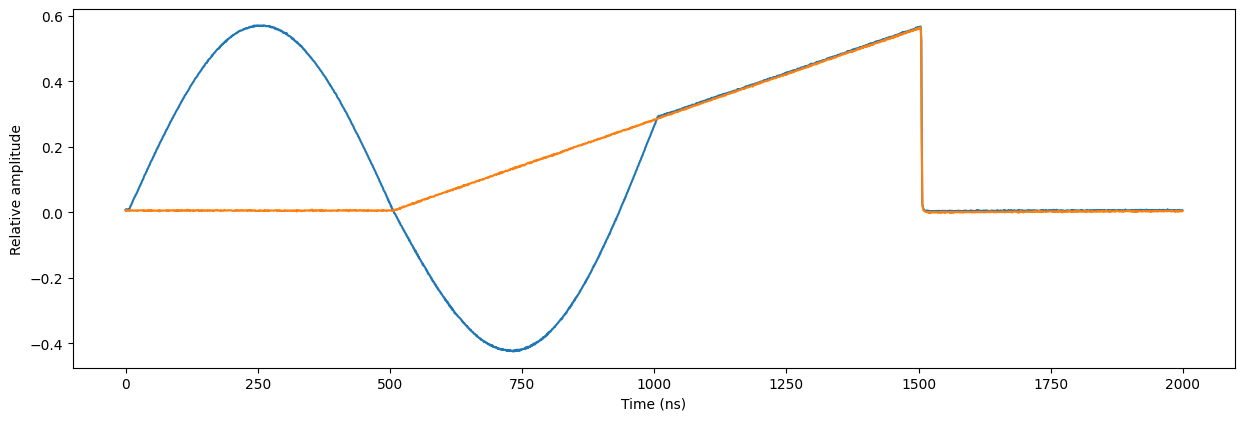

In [35]:
# Start sequencers
for seq in range(0, num_seq):
    readout_module.arm_sequencer(seq)
readout_module.start_sequencer()

# Wait for sequencers to stop (only sequencer 0 will acquire)
for seq in range(0, num_seq):
    readout_module.get_sequencer_status(seq)
readout_module.get_acquisition_status(0)

# Get acquisition
readout_module.store_scope_acquisition(0, "scope")
acq = readout_module.get_acquisitions(0)

# Plot result
fig, ax = plt.subplots(1, 1, figsize=(15, 15 / 2 / 1.61))
ax.plot(acq["scope"]["acquisition"]["scope"]["path0"]["data"][0:2000])
ax.plot(acq["scope"]["acquisition"]["scope"]["path1"]["data"][0:2000])
ax.set_xlabel("Time (ns)")
ax.set_ylabel("Relative amplitude")
plt.show()

As expected, we see a sine and sawtooth that are independently sequenced on the outputs.

Stop
----

Finally, let's close the instrument connection. One can also display a detailed snapshot containing the instrument parameters before
closing the connection by uncommenting the corresponding lines.

In [36]:
# Print an overview of the instrument parameters.
print("Snapshot:")
readout_module.print_readable_snapshot(update=True)

# Reset the cluster
cluster.reset()
print(cluster.get_system_status())

Snapshot:


cluster0_module4:
	parameter                    value
--------------------------------------------------------------------------------
in0_gain                      :	-6 (dB)
in0_offset                    :	0 (V)
in1_gain                      :	-6 (dB)
in1_offset                    :	0 (V)
marker0_inv_en                :	False 
marker1_inv_en                :	False 
marker2_inv_en                :	False 
marker3_inv_en                :	False 
out0_offset                   :	0 (V)
out1_offset                   :	0 (V)
present                       :	True 
scope_acq_avg_mode_en_path0   :	False 
scope_acq_avg_mode_en_path1   :	False 
scope_acq_sequencer_select    :	0 
scope_acq_trigger_level_path0 :	0 
scope_acq_trigger_level_path1 :	0 
scope_acq_trigger_mode_path0  :	sequencer 
scope_acq_trigger_mode_path1  :	sequencer 


cluster0_module4_sequencer0:
	parameter                       value
--------------------------------------------------------------------------------
connect_acq_I                    :	in0 
connect_acq_Q                    :	in1 
connect_out0                     :	I 
connect_out1                     :	Q 
cont_mode_en_awg_path0           :	False 
cont_mode_en_awg_path1           :	False 
cont_mode_waveform_idx_awg_path0 :	0 
cont_mode_waveform_idx_awg_path1 :	0 
demod_en_acq                     :	False 
gain_awg_path0                   :	1 
gain_awg_path1                   :	0 
integration_length_acq           :	1024 
marker_ovr_en                    :	False 
marker_ovr_value                 :	0 
mixer_corr_gain_ratio            :	1 
mixer_corr_phase_offset_degree   :	-0 
mod_en_awg                       :	False 
nco_freq                         :	0 (Hz)
nco_phase_offs                   :	0 (Degrees)
nco_prop_delay_comp              :	0 (ns)
nco_prop_delay_comp_en           :	False (ns)


cluster0_module4_sequencer1:
	parameter                       value
--------------------------------------------------------------------------------
connect_acq_I                    :	in0 
connect_acq_Q                    :	in1 
connect_out0                     :	I 
connect_out1                     :	I 
cont_mode_en_awg_path0           :	False 
cont_mode_en_awg_path1           :	False 
cont_mode_waveform_idx_awg_path0 :	0 
cont_mode_waveform_idx_awg_path1 :	0 
demod_en_acq                     :	False 
gain_awg_path0                   :	1 
gain_awg_path1                   :	0 
integration_length_acq           :	1024 
marker_ovr_en                    :	False 
marker_ovr_value                 :	0 
mixer_corr_gain_ratio            :	1 
mixer_corr_phase_offset_degree   :	-0 
mod_en_awg                       :	False 
nco_freq                         :	0 (Hz)
nco_phase_offs                   :	0 (Degrees)
nco_prop_delay_comp              :	0 (ns)
nco_prop_delay_comp_en           :	False (ns)


cluster0_module4_sequencer2:
	parameter                       value
--------------------------------------------------------------------------------
connect_acq_I                    :	in0 
connect_acq_Q                    :	in1 
connect_out0                     :	I 
connect_out1                     :	Q 
cont_mode_en_awg_path0           :	False 
cont_mode_en_awg_path1           :	False 
cont_mode_waveform_idx_awg_path0 :	0 
cont_mode_waveform_idx_awg_path1 :	0 
demod_en_acq                     :	False 
gain_awg_path0                   :	1 
gain_awg_path1                   :	1 
integration_length_acq           :	1024 
marker_ovr_en                    :	False 
marker_ovr_value                 :	0 
mixer_corr_gain_ratio            :	1 
mixer_corr_phase_offset_degree   :	-0 
mod_en_awg                       :	False 
nco_freq                         :	0 (Hz)
nco_phase_offs                   :	0 (Degrees)
nco_prop_delay_comp              :	0 (ns)
nco_prop_delay_comp_en           :	False (ns)


cluster0_module4_sequencer3:
	parameter                       value
--------------------------------------------------------------------------------
connect_acq_I                    :	in0 
connect_acq_Q                    :	in1 
connect_out0                     :	I 
connect_out1                     :	Q 
cont_mode_en_awg_path0           :	False 
cont_mode_en_awg_path1           :	False 
cont_mode_waveform_idx_awg_path0 :	0 
cont_mode_waveform_idx_awg_path1 :	0 
demod_en_acq                     :	False 
gain_awg_path0                   :	1 
gain_awg_path1                   :	1 
integration_length_acq           :	1024 
marker_ovr_en                    :	False 
marker_ovr_value                 :	0 
mixer_corr_gain_ratio            :	1 
mixer_corr_phase_offset_degree   :	-0 
mod_en_awg                       :	False 
nco_freq                         :	0 (Hz)
nco_phase_offs                   :	0 (Degrees)
nco_prop_delay_comp              :	0 (ns)
nco_prop_delay_comp_en           :	False (ns)


cluster0_module4_sequencer4:
	parameter                       value
--------------------------------------------------------------------------------
connect_acq_I                    :	in0 
connect_acq_Q                    :	in1 
connect_out0                     :	I 
connect_out1                     :	Q 
cont_mode_en_awg_path0           :	False 
cont_mode_en_awg_path1           :	False 
cont_mode_waveform_idx_awg_path0 :	0 
cont_mode_waveform_idx_awg_path1 :	0 
demod_en_acq                     :	False 
gain_awg_path0                   :	1 
gain_awg_path1                   :	1 
integration_length_acq           :	1024 
marker_ovr_en                    :	False 
marker_ovr_value                 :	0 
mixer_corr_gain_ratio            :	1 
mixer_corr_phase_offset_degree   :	-0 
mod_en_awg                       :	False 
nco_freq                         :	0 (Hz)
nco_phase_offs                   :	0 (Degrees)
nco_prop_delay_comp              :	0 (ns)
nco_prop_delay_comp_en           :	False (ns)


cluster0_module4_sequencer5:
	parameter                       value
--------------------------------------------------------------------------------
connect_acq_I                    :	in0 
connect_acq_Q                    :	in1 
connect_out0                     :	I 
connect_out1                     :	Q 
cont_mode_en_awg_path0           :	False 
cont_mode_en_awg_path1           :	False 
cont_mode_waveform_idx_awg_path0 :	0 
cont_mode_waveform_idx_awg_path1 :	0 
demod_en_acq                     :	False 
gain_awg_path0                   :	1 
gain_awg_path1                   :	1 
integration_length_acq           :	1024 
marker_ovr_en                    :	False 
marker_ovr_value                 :	0 
mixer_corr_gain_ratio            :	1 
mixer_corr_phase_offset_degree   :	-0 
mod_en_awg                       :	False 
nco_freq                         :	0 (Hz)
nco_phase_offs                   :	0 (Degrees)
nco_prop_delay_comp              :	0 (ns)
nco_prop_delay_comp_en           :	False (ns)


Status: OKAY, Flags: NONE, Slot flags: NONE
